In [1]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from timeit import default_timer as timer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score
from wordcloud import WordCloud
from collections import Counter
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from statistics import mean
from sklearn.metrics import hamming_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

%matplotlib inline


In [2]:
train_set=pd.read_csv('train.csv')
test_set=pd.read_csv('test.csv')
test_labels=pd.read_csv('test_labels.csv')

train_set.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
train_set.describe().T

,count,mean,std,min,25%,50%,75%,max
toxic,159571.0,0.095844,0.294379,0.0,0.0,0.0,0.0,1.0
severe_toxic,159571.0,0.009996,0.099477,0.0,0.0,0.0,0.0,1.0
obscene,159571.0,0.052948,0.223931,0.0,0.0,0.0,0.0,1.0
threat,159571.0,0.002996,0.054650,0.0,0.0,0.0,0.0,1.0
insult,159571.0,0.049364,0.216627,0.0,0.0,0.0,0.0,1.0
identity_hate,159571.0,0.008805,0.093420,0.0,0.0,0.0,0.0,1.0


In [4]:
test_set.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [6]:
print("Shape of training data: {}".format(train_set.shape))
print("\nShape of test data: {}".format(test_set.shape))

Shape of training data: (159571, 8)

Shape of test data: (153164, 2)


<AxesSubplot:xlabel='comment_text'>

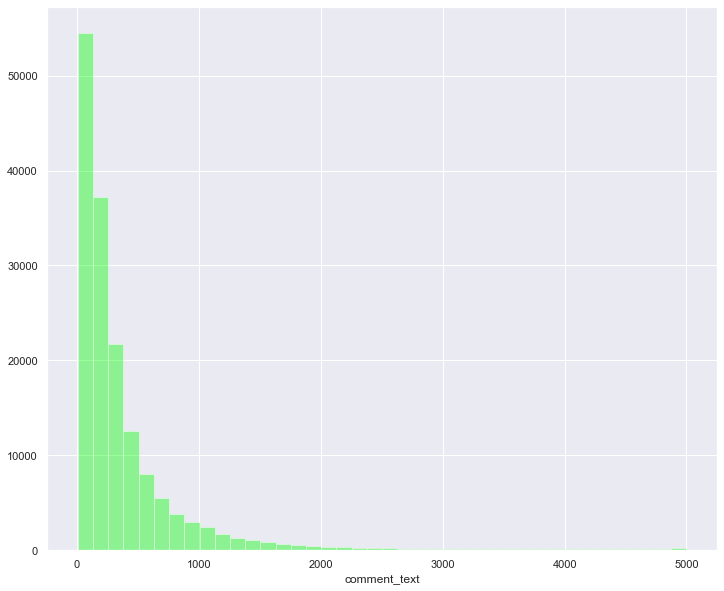

In [7]:
plt.figure(figsize=(12,10))
sns.set(color_codes=True)
comment_length=train_set.comment_text.str.len()
sns.distplot(comment_length, kde=False, bins=40,color="lime")

<AxesSubplot:title={'center':'Frequency of labels'}>

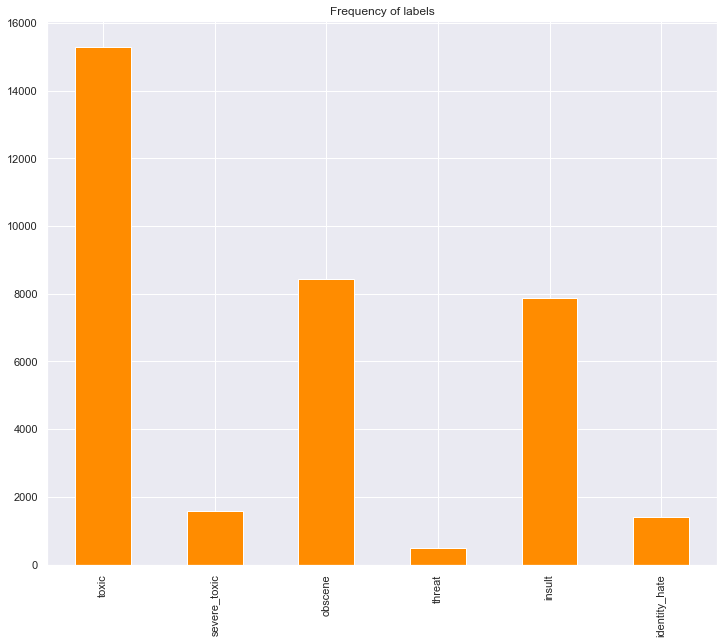

In [8]:
plt.figure(figsize=(12,10))
toxicity_labels=train_set[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

toxicity_labels_count=toxicity_labels.sum()

toxicity_labels_count.plot(kind='bar', title='Frequency of labels', color='darkorange')

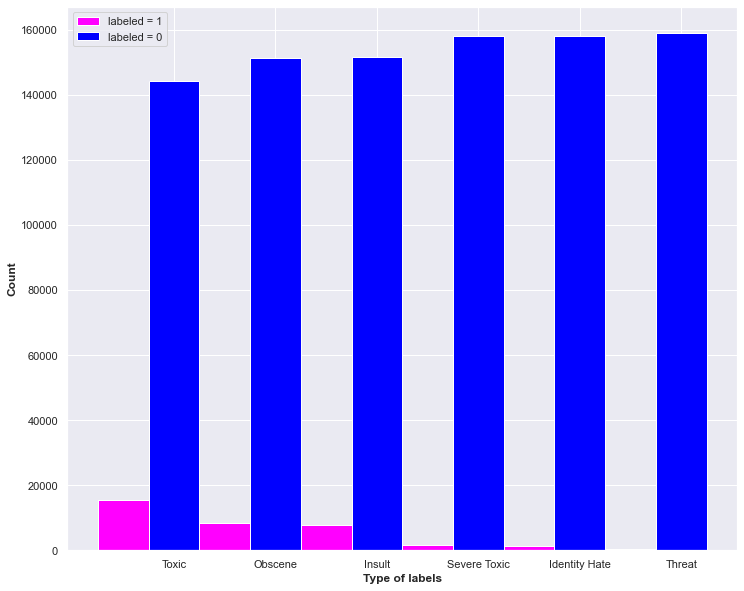

In [9]:
bad_comments=[sum(train_set['toxic']==1),
              sum(train_set['obscene']==1),
              sum(train_set['insult']==1),
              sum(train_set['severe_toxic']==1),
              sum(train_set['identity_hate']==1),
              sum(train_set['threat']==1)]

good_comments=[sum(train_set['toxic']==0),
              sum(train_set['obscene']==0),
              sum(train_set['insult']==0),
              sum(train_set['severe_toxic']==0),
              sum(train_set['identity_hate']==0),
              sum(train_set['threat']==0)]

x_coord_bad=np.arange(len(bad_comments))

x_coord_good=[]
for x in x_coord_bad:
    x_coord_good.append(x + 0.5)

plt.figure(figsize=(12,10))
plt.bar(x_coord_bad, bad_comments, color='magenta', width=0.5, label='labeled = 1')
plt.bar(x_coord_good, good_comments, color='blue', width=0.5, label='labeled = 0')
plt.xlabel('Type of labels', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xticks([x + 0.5 for x in range(len(bad_comments))], ['Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate','Threat'])
plt.legend()
plt.show()

<AxesSubplot:>

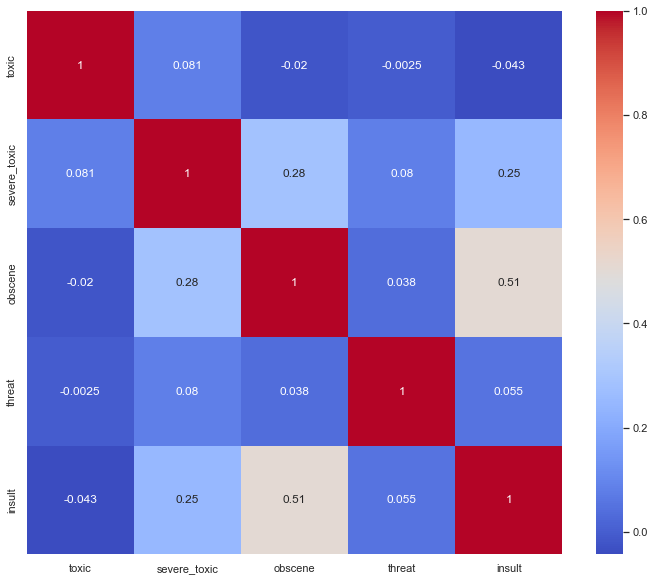

In [10]:
sum_rows=train_set.iloc[:, 2:].sum(axis=1)
label_columns=train_set.iloc[:, 2:-1]

plt.figure(figsize=(12,10))
data=label_columns[sum_rows > 0].corr()
sns.heatmap(data, xticklabels=data.columns.values, yticklabels=data.columns.values, annot=True, cmap="coolwarm")

In [11]:
def get_wordcloud(label_name, title=None):
    bad_context=train_set[train_set[label_name]==1]
    bad_text=bad_context.comment_text
    processed_text=pd.Series(bad_text).str.cat(sep='')
    wordcloud=WordCloud(width=1600, height=800, max_font_size=200).generate(processed_text)
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud.recolor(colormap="tab20c"), interpolation='bilinear')
    plt.axis("off")
    plt.title(title, size=25)
    plt.show()
    
    

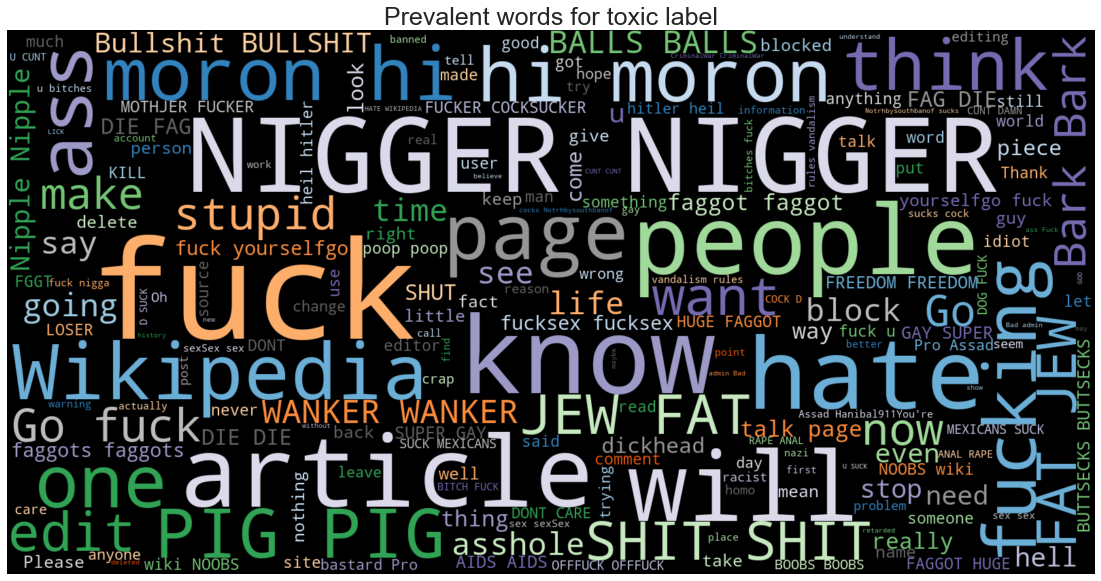

In [12]:
get_wordcloud("toxic","Prevalent words for toxic label")

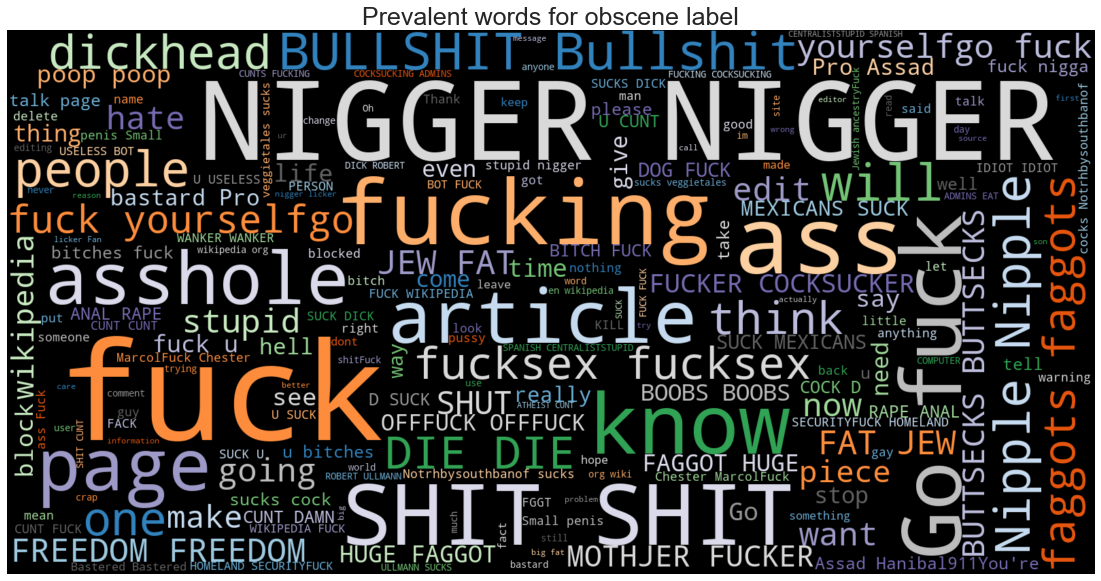

In [13]:
get_wordcloud("obscene","Prevalent words for obscene label")

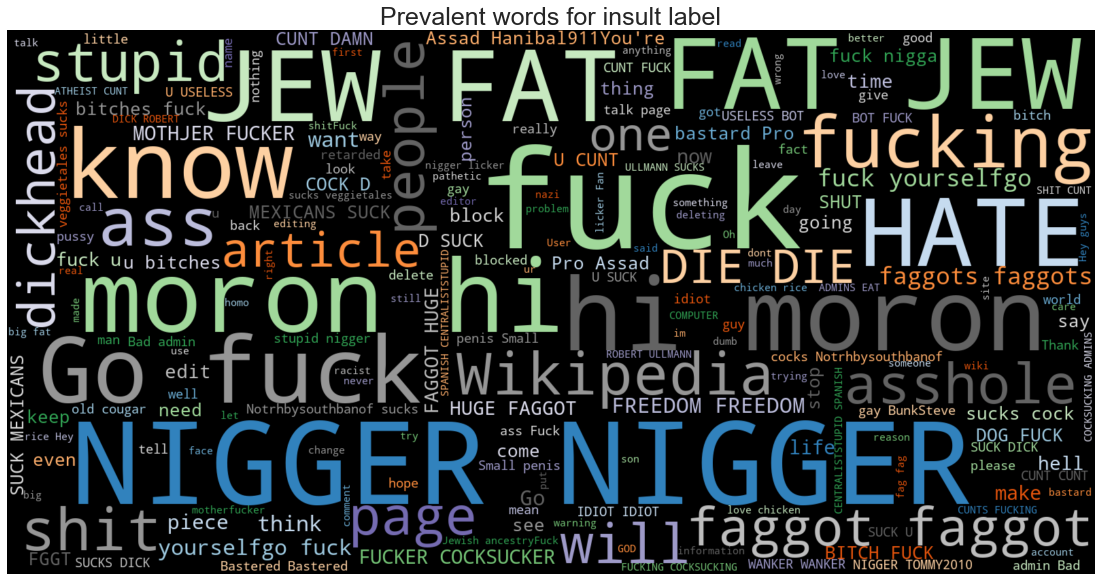

In [14]:
get_wordcloud("insult","Prevalent words for insult label")

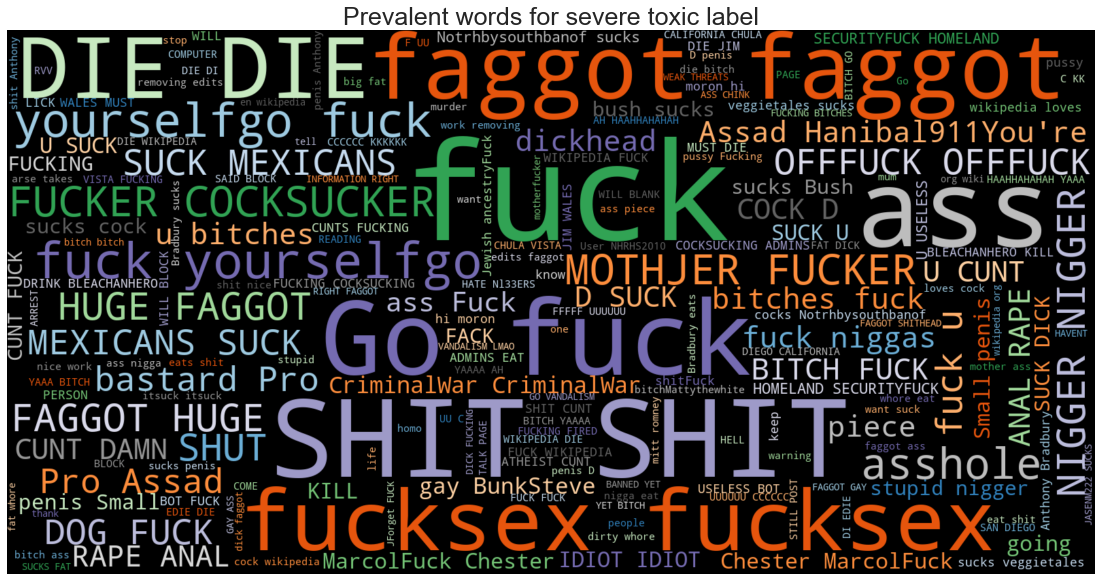

In [15]:
get_wordcloud("severe_toxic","Prevalent words for severe toxic label")

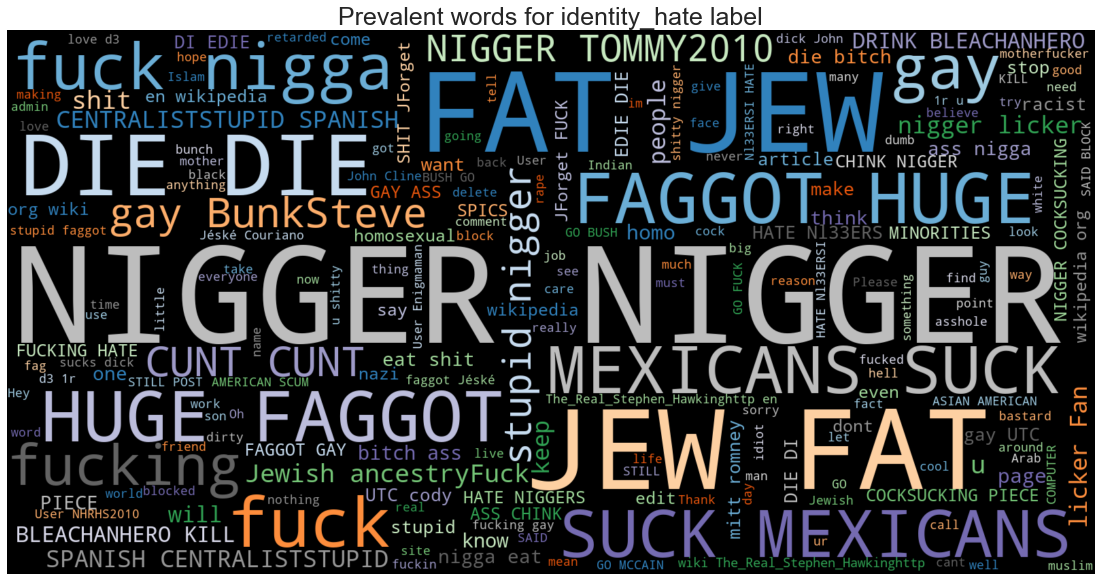

In [16]:
get_wordcloud("identity_hate","Prevalent words for identity_hate label")

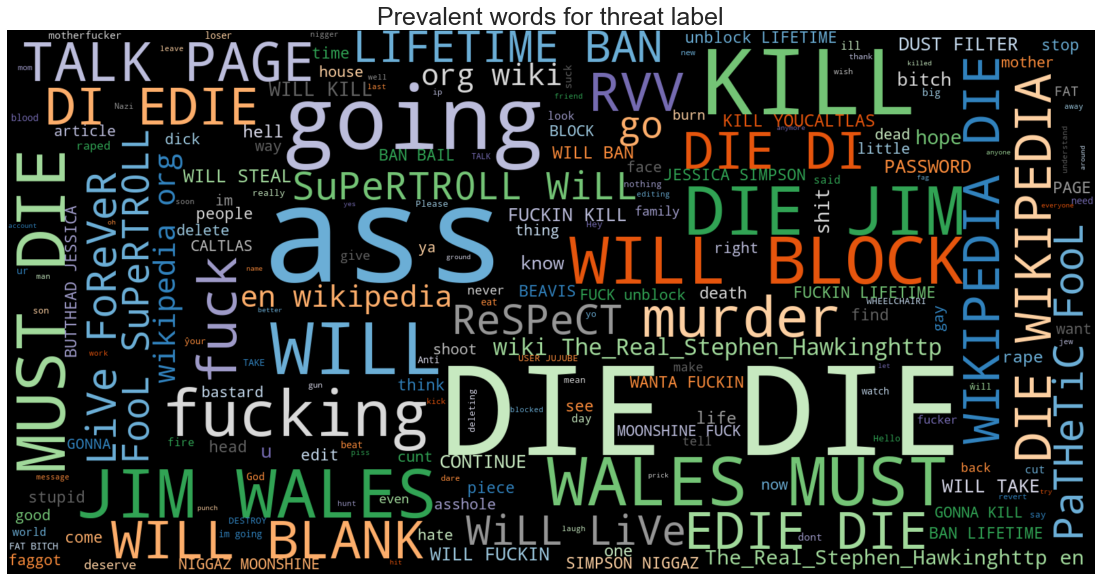

In [17]:
get_wordcloud("threat","Prevalent words for threat label")

In [18]:
toxicity_labels=["toxic","severe_toxic","obscene","threat", "insult", "identity_hate"]

In [19]:
def tokenize_text(text):
    text=text.lower()
    regular_expr=re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    without_punctuation=regular_expr.sub(" ",text)
    
    tokenize_words=without_punctuation.split(' ')
    tokenize_words=[word.encode('ascii','ignore').decode('ascii') for word in tokenize_words]
    
    lemmatizer=WordNetLemmatizer()
    tokenize_words=[lemmatizer.lemmatize(word) for word in tokenize_words]
    
    tokenize_words=[word for word in tokenize_words if len(word) > 2]
    
    return tokenize_words

In [20]:
tfidf_vector=TfidfVectorizer(ngram_range=(1, 1), 
                            analyzer='word',
                            tokenizer=tokenize_text,
                            stop_words='english',
                            strip_accents='unicode', use_idf=1, min_df=10)

X_train=tfidf_vector.fit_transform(train_set['comment_text'])
X_test=tfidf_vector.transform(test_set['comment_text'])

tfidf_vector.get_feature_names()[0:5]

['aaa', 'aap', 'aardvark', 'aaron', 'aba']

In [21]:
lr_classifier=LogisticRegression()
mnb_classifier=MultinomialNB()
lsvc_classifier=LinearSVC()

In [22]:
def cross_validation_score(classifier, X_train, y_train):
    metrics=[]
    classifier_name=classifier.__class__.__name__.split('.')[-1]
    for label in toxicity_labels:
        f1=cross_val_score(classifier, X_train, y_train[label], cv=10, scoring='f1')
        recall=cross_val_score(classifier, X_train, y_train[label], cv=10, scoring='recall')
        metrics.append([classifier_name, label, f1.mean(), recall.mean()])
    
    return metrics
        

In [23]:
cv1=pd.DataFrame(cross_validation_score(lr_classifier, X_train, train_set))
cv2=pd.DataFrame(cross_validation_score(mnb_classifier, X_train, train_set))
cv3=pd.DataFrame(cross_validation_score(lsvc_classifier, X_train, train_set))

In [24]:
cv=pd.concat([cv1, cv2, cv3])
cv.columns=['Model', 'Label', 'F1 score', 'Recall']
cv=cv.reset_index()

In [25]:
cv[['Model', 'Label', 'F1 score', 'Recall']]

,Model,Label,F1 score,Recall
0,LogisticRegression,toxic,0.731339,0.610500
1,LogisticRegression,severe_toxic,0.351530,0.256431
2,LogisticRegression,obscene,0.747363,0.637002
3,LogisticRegression,threat,0.206632,0.123316
4,LogisticRegression,insult,0.638177,0.523546
5,LogisticRegression,identity_hate,0.310379,0.200750
6,MultinomialNB,toxic,0.636562,0.482999
7,MultinomialNB,severe_toxic,0.042244,0.021938
8,MultinomialNB,obscene,0.622148,0.469167
9,MultinomialNB,threat,0.000000,0.000000


In [26]:
def evaluation_metrics(classifier, X_train, y_train, X_test, y_test):
    metrics=[]
    ham_loss=[]
    classifier_name=classifier.__class__.__name__.split('.')[-1]
    
    predictions=pd.DataFrame()
    predictions['id']=test_labels['id']
    
    for label in toxicity_labels:
        classifier.fit(X_train, y_train[label])
        predicted_label=classifier.predict(X_test)
        predictions[label]=predicted_label
        
        recall=recall_score(y_test[y_test[label]!=-1][label], predicted_label[y_test[label]!=-1], average="weighted")
        
        f1=f1_score(y_test[y_test[label]!=-1][label], predicted_label[y_test[label]!=-1], average="weighted")
        
        confusion_mat=confusion_matrix(y_test[y_test[label]!=-1][label], predicted_label[y_test[label]!=-1])
        
        metrics.append([classifier_name, label, f1, recall, confusion_mat])
        
    hloss_value = hamming_loss(test_labels[test_labels['toxic'] != -1].iloc[:, 1:7],
                                      predictions[test_labels['toxic'] != -1].iloc[:, 1:7])
    
    ham_loss.append([classifier_name, hloss_value])
    
    return metrics, ham_loss

In [27]:
scores_1, hloss_1=evaluation_metrics(lr_classifier, X_train, train_set, X_test, test_labels)
scores_2, hloss_2=evaluation_metrics(mnb_classifier, X_train, train_set, X_test, test_labels)
scores_3, hloss_3=evaluation_metrics(lsvc_classifier, X_train, train_set, X_test, test_labels)


In [28]:
scores_1=pd.DataFrame(scores_1)
scores_2=pd.DataFrame(scores_2)
scores_3=pd.DataFrame(scores_3)
all_scores=pd.concat([scores_1,scores_2,scores_3])
all_scores.columns=['Model', 'Label', 'F1 score', 'Recall', 'Confusion Matrix']
all_scores_mod=all_scores.reset_index()

all_scores_mod[['Model', 'Label', 'F1 score', 'Recall', 'Confusion Matrix']]

,Model,Label,F1 score,Recall,Confusion Matrix
0,LogisticRegression,toxic,0.937031,0.935728,"[[55541, 2347], [1765, 4325]]"
1,LogisticRegression,severe_toxic,0.992762,0.993123,"[[63426, 185], [255, 112]]"
2,LogisticRegression,obscene,0.964267,0.965957,"[[59549, 738], [1440, 2251]]"
3,LogisticRegression,threat,0.995725,0.996530,"[[63723, 44], [178, 33]]"
4,LogisticRegression,insult,0.961200,0.964175,"[[59914, 637], [1655, 1772]]"
5,LogisticRegression,identity_hate,0.988378,0.990465,"[[63179, 87], [523, 189]]"
6,MultinomialNB,toxic,0.930919,0.935196,"[[56587, 1301], [2845, 3245]]"
7,MultinomialNB,severe_toxic,0.992145,0.994436,"[[63599, 12], [344, 23]]"
8,MultinomialNB,obscene,0.957902,0.962987,"[[59929, 358], [2010, 1681]]"
9,MultinomialNB,threat,0.995056,0.996702,"[[63767, 0], [211, 0]]"


<AxesSubplot:title={'center':'Metrics for Logistic Regression classifier'}, xlabel='Label'>

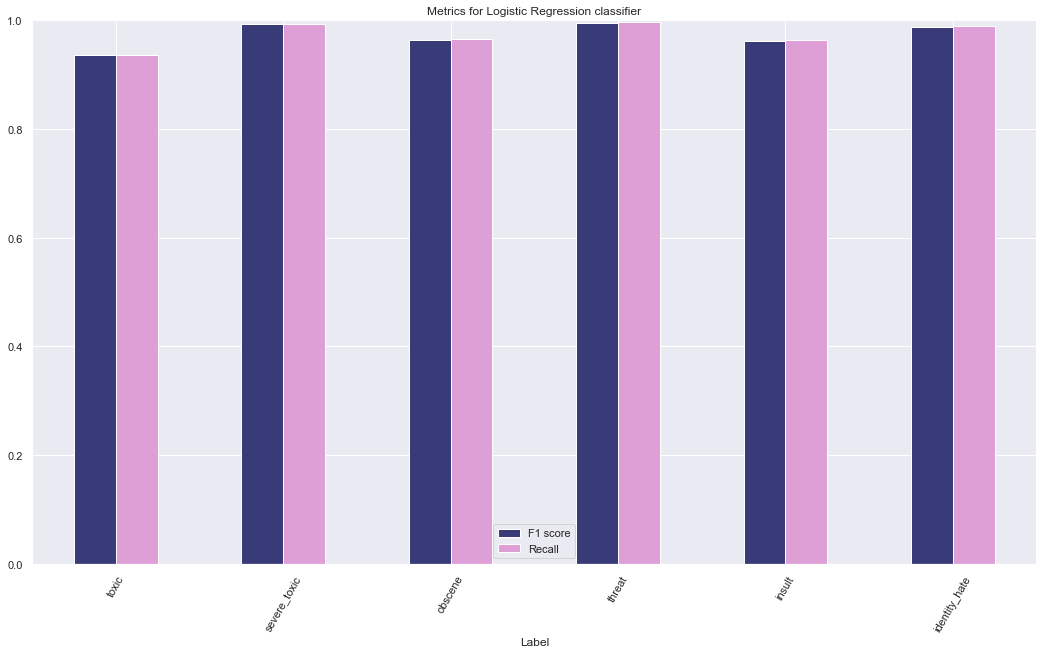

In [29]:
bar_mnb=all_scores[all_scores.Model=="LogisticRegression"]
bar_mnb.set_index(["Label"], inplace=True)
bar_mnb.plot(figsize=(18,10), kind='bar', rot=60, ylim=(0.0,1),title='Metrics for Logistic Regression classifier', colormap='tab20b')

<AxesSubplot:title={'center':'Metrics for Multinomial Naive Bayes classifier'}, xlabel='Label'>

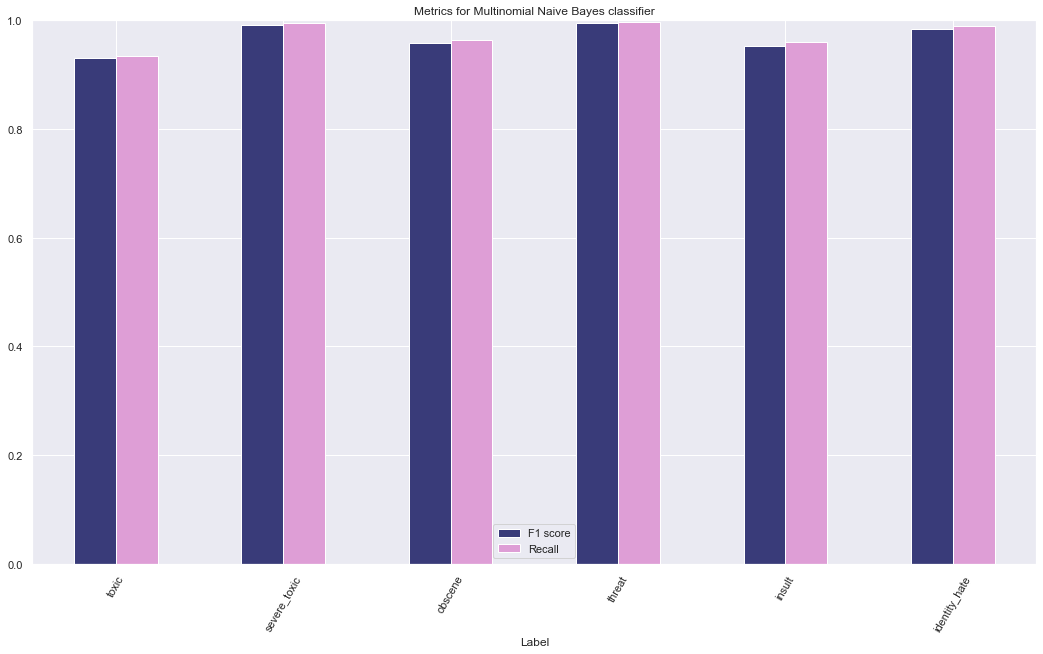

In [30]:
bar_mnb=all_scores[all_scores.Model=="MultinomialNB"]
bar_mnb.set_index(["Label"], inplace=True)
bar_mnb.plot(figsize=(18,10), kind='bar', rot=60, ylim=(0.0,1),title='Metrics for Multinomial Naive Bayes classifier', colormap='tab20b')

<AxesSubplot:title={'center':'Metrics for LinearSVC classifier'}, xlabel='Label'>

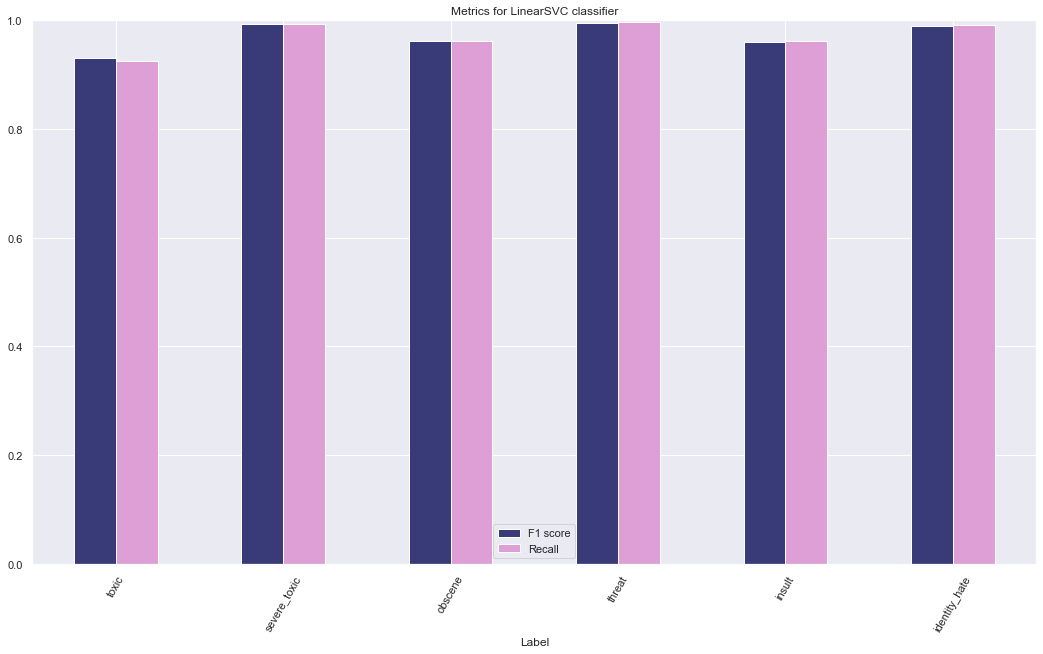

In [31]:
bar_mnb=all_scores[all_scores.Model=="LinearSVC"]
bar_mnb.set_index(["Label"], inplace=True)
bar_mnb.plot(figsize=(18,10), kind='bar', rot=60, ylim=(0.0,1),title='Metrics for LinearSVC classifier', colormap='tab20b')

In [32]:
def display_conf_matrix(matrix):
    matrix=matrix.astype('float')/matrix.sum(axis=1)[:, np.newaxis]
    ax=plt.axes()
    sns.heatmap(matrix,cmap='cool',xticklabels=("Non-toxic","Toxic"),yticklabels=("Non-toxic","Toxic"),fmt='.2f',linewidths=1.5,linecolor='orangered',annot=True,annot_kws={"size":14})
    plt.ylabel('True',fontsize=20)
    plt.xlabel('Predicted', fontsize=20)
    plt.show()

In [33]:
def build_conf_matrix(label):
    labels={"toxic":0, "severe_toxic":1 , "obscene":2, "threat":3, "insult": 4, "identity_hate":5}
    index=labels[label]
    for i in range(index, len(all_scores_mod), 6):
        print(f"\n ------------ {all_scores_mod['Model'][i]} -----------------------------")
        matrix=all_scores_mod['Confusion Matrix'][i]
        display_conf_matrix(matrix)
        


 ------------ LogisticRegression -----------------------------


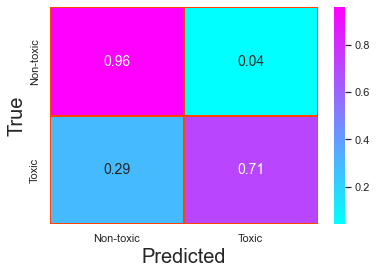


 ------------ MultinomialNB -----------------------------


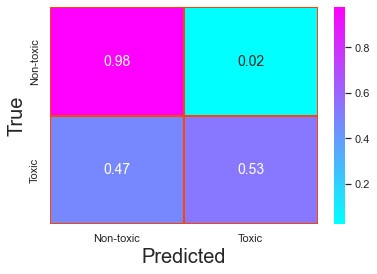


 ------------ LinearSVC -----------------------------


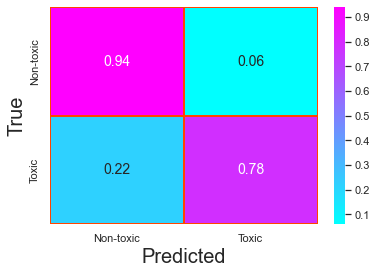

In [34]:
build_conf_matrix("toxic")

In [35]:
hloss_1_df=pd.DataFrame(hloss_1)
hloss_2_df=pd.DataFrame(hloss_2)
hloss_3_df=pd.DataFrame(hloss_3)

combined_hloss=pd.concat([hloss_1_df, hloss_2_df, hloss_3_df])
combined_hloss.columns=['Model', 'Hamming loss']
combined_hloss_mod=combined_hloss.reset_index()
combined_hloss_mod[['Model','Hamming loss']]


,Model,Hamming loss
0,LogisticRegression,0.025670
1,MultinomialNB,0.026939
2,LinearSVC,0.028476


In [36]:
labels=["toxic", "severe_toxic", "obscene",
               "threat", "insult", "identity_hate"]

In [37]:
lr_pipe=Pipeline([('lr',LogisticRegression(class_weight="balanced"))])
linear_svm_pipe=Pipeline([('svm', LinearSVC(class_weight={1:20}))])
pipelines=[lr_pipe, linear_svm_pipe]

report_cards=[]

for pipe in pipelines:
    train_time_values=[]
    f1_scores=[]
    hlosses=[]
    recall_values=[]
    predictions=pd.DataFrame()
    
    predictions['id']=test_labels['id']    
    for label in labels:
        start=timer()
        pipe.fit(X_train, train_set[label])
        train_time=timer()-start
        predicted_label=pipe.predict(X_test)
        predictions[label]=predicted_label
        
        f1_scores.append(f1_score(test_labels[test_labels[label]!=-1][label], predicted_label[test_labels[label]!=-1], average="weighted"))
        recall_values.append(recall_score(test_labels[test_labels[label]!=-1][label],predicted_label[test_labels[label]!=-1],average="weighted"))
        
        train_time_values.append(train_time)
        
        classifier_name=pipe.steps[-1][1].__class__.__name__.split('.')[-1]
        
    hloss=hamming_loss(test_labels[test_labels['toxic']!=-1].iloc[:, 1:7], predictions[test_labels['toxic']!=-1].iloc[:, 1:7])
        
    report_card=[classifier_name, mean(f1_scores), mean(recall_values), hloss, mean(train_time_values) ]
    
    report_cards.append(report_card)
    
        
    


In [38]:
report_cards_df=pd.DataFrame(report_cards)
report_cards_df.columns=["Model", "F1 score", "Recall", "Hamming loss", "Training time"]
report_cards_df

,Model,F1 score,Recall,Hamming loss,Training time
0,LogisticRegression,0.947931,0.934068,0.065932,4.312840
1,LinearSVC,0.951508,0.941634,0.058366,9.461034


In [39]:
lr_classifier=LogisticRegression()

parameter_grid={'solver':['newton-cg', 'lbfgs', 'liblinear'], 'class_weight':[None, 'balanced']}

cross_validation=StratifiedKFold(n_splits=5)

grid=GridSearchCV(lr_classifier, param_grid=parameter_grid, cv=cross_validation, scoring='f1')

grid.fit(X_train, train_set['toxic'])

print('Best parameters found by Grid Search: {}'.format(grid.best_params_))

grid.best_estimator_

Best parameters found by Grid Search: {'class_weight': None, 'solver': 'liblinear'}


LogisticRegression(solver='liblinear')

In [40]:
svm_classifier=LinearSVC()

parameter_grid={'class_weight':[None,'balanced'], 'C':[1,5,10]}

cross_validation=StratifiedKFold(n_splits=5)

grid=GridSearchCV(svm_classifier, param_grid=parameter_grid, cv=cross_validation, scoring='f1')

grid.fit(X_train, train_set['toxic'])

print('Best parameters found by Grid Search: {}'.format(grid.best_params_))

grid.best_estimator_

Best parameters found by Grid Search: {'C': 1, 'class_weight': None}


LinearSVC(C=1)

In [41]:
svm_classifier = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
                    intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                    multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
                    verbose=0)

lr_classifier = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                     intercept_scaling=1, max_iter=100, multi_class='auto',
                                     n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
                                     tol=0.0001, verbose=0, warm_start=False)

In [42]:
report_cards_tuned = []

for model in [svm_classifier, lr_classifier]:
    training_time_values = []
    predictions = pd.DataFrame()
    predictions['id'] = test_labels['id']
    f1_scores = []
    recall_values = []
    hlosses = []

    for label in labels:
        start = timer()
        model.fit(X_train, train_set[label])
        training_time_values.append(timer() - start)
        predicted_label = model.predict(X_test)
        predictions[label] = predicted_label

        f1_scores.append(f1_score(test_labels[test_labels[label] != -1][label],
                                  predicted_label[test_labels[label] != -1],
                                  average="weighted"))
        recall_values.append(recall_score(test_labels[test_labels[label] != -1][label],
                                          predicted_label[test_labels[label] != -1],
                                          average="weighted"))
        classifier_name = model.__class__.__name__

    hloss = hamming_loss(test_labels[test_labels['toxic'] != -1].iloc[:, 1:7], 
                         predictions[test_labels['toxic'] != -1].iloc[:, 1:7])

    report_card = [classifier_name, mean(f1_scores), mean(recall_values), hloss, sum(training_time_values)]

    report_cards_tuned.append(report_card)

In [44]:
report_cards_tuned_df=pd.DataFrame(report_cards_tuned)
report_cards_tuned_df.columns=["Model", "F1 score", "Recall", "Hamming Loss", "Training_time"]
report_cards_tuned_df

,Model,F1 score,Recall,Hamming Loss,Training_time
0,LinearSVC,0.971706,0.971524,0.028476,6.250244
1,LogisticRegression,0.973227,0.974330,0.025670,20.712323


In [45]:
adapb_classifier=AdaBoostClassifier()
gradb_classifier=GradientBoostingClassifier()
xgb_classifier=xgb.XGBClassifier()

In [47]:
ensemble_clf = VotingClassifier(estimators=[('lr', lr_classifier),
                                            ('svm', svm_classifier),
                                            ('xgb', xgb_classifier)], voting='hard')
ensemble_score_df = []
f1_values = []
recall_values = []
hl = []
training_time = []

predict_df = pd.DataFrame()
predict_df['id'] = test_labels['id']
for label in labels:
    start = timer()
    ensemble_clf.fit(X_train, train_set[label])
    training_time.append(timer() - start)
    predicted = ensemble_clf.predict(X_test)
    predict_df[label] = predicted
    f1_values.append(f1_score(test_labels[test_labels[label] != -1][label],
                              predicted[test_labels[label] != -1],
                              average="weighted"))
    recall_values.append(recall_score(test_labels[test_labels[label] != -1][label],
                                      predicted[test_labels[label] != -1],
                                      average="weighted"))
    name = 'Ensemble'

hamming_loss_score = hamming_loss(test_labels[test_labels['toxic'] != -1].iloc[:, 1:7],
                                  predict_df[test_labels['toxic'] != -1].iloc[:, 1:7])

val = [name, mean(f1_values), mean(recall_values),
       hamming_loss_score, mean(training_time)]
ensemble_score_df.append(val)


# printing the values
ensemble_score = pd.DataFrame(ensemble_score_df,)
ensemble_score.columns = ['Model', 'F1',
                          'Recall', 'Hamming_Loss', 'Training_Time']
ensemble_score

,Model,F1,Recall,Hamming_Loss,Training_Time
0,Ensemble,0.973258,0.973947,0.026053,94.136931


In [48]:
boosting_models=[adapb_classifier, gradb_classifier, xgb_classifier]

In [49]:
boosting_score_df = []
for model in boosting_models:
    f1_values = []
    recall_values = []
    training_time = []
    hloss = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_labels['id']

    for idx, label in enumerate(labels):
        start = timer()
        model.fit(X_train, train_set[label])
        predicted = model.predict(X_test)
        training_time.append(timer() - start)
        predict_df[label] = predicted
        f1_values.append(f1_score(test_labels[test_labels[label] != -1][label],
                                  predicted[test_labels[label] != -1],
                                  average="weighted"))
        recall_values.append(recall_score(test_labels[test_labels[label] != -1][label],
                                          predicted[test_labels[label] != -1],
                                          average="weighted"))
        name = model.__class__.__name__

    hamming_loss_score = hamming_loss(test_labels[test_labels['toxic'] != -1].iloc[:, 1:7],
                                      predict_df[test_labels['toxic'] != -1].iloc[:, 1:7])

    val = [name, mean(f1_values), mean(recall_values),
           hamming_loss_score, mean(training_time)]

    boosting_score_df.append(val)

In [51]:
boosted_scores=pd.DataFrame(boosting_score_df)
boosted_scores.columns=["Model", "F1 score", "Recall", "Hamming loss", "Training time"]
boosted_scores

,Model,F1 score,Recall,Hamming loss,Training time
0,AdaBoostClassifier,0.967605,0.969771,0.030229,48.707371
1,GradientBoostingClassifier,0.969111,0.971782,0.028218,200.550606
2,XGBClassifier,0.972642,0.973103,0.026897,84.688097


In [61]:
def display_curves(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1,0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.xlabel("No. of Training examples")
    plt.ylabel('Score')
    
    train_sizes, train_scores, test_scores=learning_curve(estimator, X, y, train_sizes=train_sizes, cv=cv, n_jobs=n_jobs)
    train_scores_mean=np.mean(train_scores, axis=1)
    train_scores_std=np.std(train_scores, axis=1)
    test_scores_mean=np.mean(test_scores, axis=1)
    test_scores_std=np.std(test_scores, axis=1)
    
    plt.fil_between(train_sizes,train_scores_mean-train_scores_std, train_scores_mean + train_scores_std, aplha=0.1,color="o")
    plt.fill_between(train_sizes,test_scores_mean-test_scores_std, test_scores_mean + test_scores_std, aplha=0.1,color="b" )
    plt.plot(train_sizes, train_scores_mean, 'o-', color="magenta", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="deepskyblue", label="Cross validation score")
    plt.legend(loc="best")
    
    return plt

In [71]:
def display_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=train_sizes, cv=cv, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean-test_scores_std,test_scores_mean+test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="magenta", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="deepskyblue", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

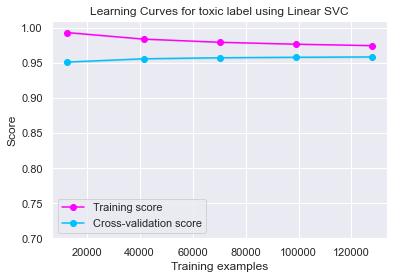

In [69]:
cross_validation = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
                      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
                      verbose=0)
display_curve(estimator, "Learning Curves for toxic label using Linear SVC" , X_train,
                    train_set['toxic'], ylim=(0.7, 1.01), cv=cv, n_jobs=4)